In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import torchvision.transforms.functional as F

import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
from skimage import transform
import PIL

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sys
#import elasticdeform
import matplotlib.image as mpimg
import random
from torch.nn import CrossEntropyLoss, Sequential, Linear

from torch.autograd import Variable
import imageio
import cv2
from skimage import exposure

from IPython.display import clear_output
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Preprocess

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/mnist_train.csv')
test_df = pd.read_csv('/content/drive/My Drive/mnist_test.csv')

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def process(data_df, test = None):
    data = []
    
    for i in range(data_df.shape[0]):
        item = {}
        
        row_list = np.array(train_df.iloc[i, 1:])
        img = np.reshape(row_list, (28, 28))
        img = np.expand_dims(img, axis=2)
        
        item['Image'] = t.from_numpy(img)
        
        if test == None:
            item['Class'] = train_df.iloc[i, 0]
        
        data.append(item)
    
    return data
  

In [0]:
train_data = process(train_df)
test_data = process(test_df, True)

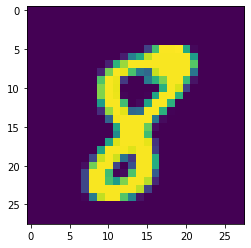

In [0]:
plt.imshow(test_data[27997]['Image'].squeeze(2).numpy())

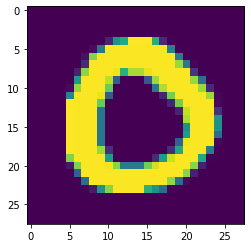

In [0]:
plt.imshow(train_data[4]['Image'].squeeze(2).numpy())

### Data transformations

In [0]:
class Dataset():
    def __init__(self, data, source_transform):
        self.datas = data
        self.s_trans = source_transform
        self.to_pil = tsf.ToPILImage()
        self.to_tens = tsf.ToTensor()
        
    def __getitem__(self, index):
        data = self.datas[index]
        
        img = data['Image'].numpy()
        label = data['Class']
        
        #img = self.to_pil(img)
        
        img = self.s_trans(img)
        
#         img = self.to_tens(img)
#         img = self.norm(img)
        
        return img, label
    
    def __len__(self):
        return len(self.datas)
    
s_trans = tsf.Compose([
    tsf.ToTensor(),
   # tsf.Normalize(mean = [0.5],std = [0.5])
]
)

In [0]:
full_dataset = Dataset(train_data, s_trans)

Image shape:  torch.Size([1, 28, 28])
Data size:  41984


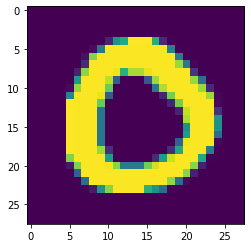

In [11]:
plt.imshow(full_dataset[4][0].squeeze(0).numpy())
print("Image shape: ", full_dataset[4][0].shape)
print("Data size: ", len(full_dataset))

### Validation

In [11]:
train1 = []
test1 = []
for i in range(0, len(full_dataset)):
    if i < 38000:
        train1.append(full_dataset[i])
    else:
        test1.append(full_dataset[i])
print(len(train1))
print(len(test1))

38000
4000


In [0]:
train_dataloader = DataLoader(train1, batch_size=100, shuffle=False)
test_dataloader = DataLoader(test1, batch_size=100)

### Train

In [0]:
dtype=t.FloatTensor

def train(network, epochs, learning_rate, loss=t.nn.CrossEntropyLoss(), optim=t.optim.Adam, use_cuda=False):
    train_loss_epochs = []
    test_loss_epochs = []
    
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    optimizer = optim(network.parameters(), learning_rate)
    
    for epoch in range(epochs):
        current_loss = []
        current_accuracy = []

        cnt1 = 0
        total = 0
        for sample in train_dataloader:
            X = sample[0]
            X = X.type(dtype)
            y = sample[1]

            X = Variable(X)
            y = Variable(y)
            
            if use_cuda:
                X = X.cuda()
                y = y.cuda()
            
            prediction = network(X)
            
            loss_batch = loss(prediction, y)
            current_loss.append(loss_batch.item())
            
            
            x = (t.argmax(prediction,dim=1)==y)

          
            for val in x:
              total+=1
              if val == True:
                cnt1+=1

            

           # current_accuracy.append(cnt1/total)
            
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        
        train_loss_epochs.append(np.mean(current_loss))
       # train_accuracy_epochs.append(np.mean(current_accuracy))
        train_accuracy_epochs.append(cnt1/total)
        
        
        current_loss = []
        current_accuracy = []

        cnt1 = 0
        total = 0
        for sample in test_dataloader:
            X = sample[0]
            X = X.type(dtype)
            y = sample[1]
            
            if use_cuda:
                X = X.cuda()
                y = y.cuda()
            
            prediction = network(X)
            
            loss_batch = loss(prediction, y)
            current_loss.append(loss_batch.item())

            x = (t.argmax(prediction,dim=1)==y)

        
            for val in x:
              total+=1
              if val == True:
                cnt1+=1
            
            current_accuracy.append(cnt1/total)
        
        test_loss_epochs.append(np.mean(current_loss))
       # test_accuracy_epochs.append(np.mean(current_accuracy))
        test_accuracy_epochs.append(cnt1/total)
        
        clear_output(True)
        
        sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                    epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                    train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
       
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs, label='Train')
        plt.plot(test_loss_epochs, label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_epochs, label='Train accuracy')
        plt.plot(test_accuracy_epochs, label='Test accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
       

### Network

In [0]:
class Net1(t.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv_layers = t.nn.Sequential(t.nn.Conv2d(1, 16, 3, padding=0), t.nn.ReLU(),
                                         t.nn.Conv2d(16, 16, 3, padding=0), t.nn.ReLU(),
                                         t.nn.MaxPool2d(2),
                                         t.nn.Conv2d(16, 32, 3, padding=0), t.nn.ReLU(),
                                         t.nn.Conv2d(32, 32, 3, padding=0), t.nn.ReLU(),
                                         t.nn.MaxPool2d(2)
                                        )
        self.linear_layers = t.nn.Sequential(t.nn.Linear(4*4*32, 10))
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.linear_layers(out)
        
        return out

In [0]:
class Net2(t.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear_layers = t.nn.Sequential(t.nn.Linear(784, 100), t.nn.ReLU(), 
                                             t.nn.Linear(100, 100), t.nn.ReLU(),
                                             t.nn.Linear(100, 10)
                                              )
        self.linear_layers2 = t.nn.Sequential(t.nn.Linear(784, 10))
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.linear_layers2(out)
        
        return out

In [0]:
use_cuda = False

In [0]:
model = Net1()

In [0]:
model = Net2()

In [0]:
if use_cuda:
    model.cuda()

Epoch 19... (Train/Test) Loss: 24.766/45.223	Accuracy: 0.903/0.879

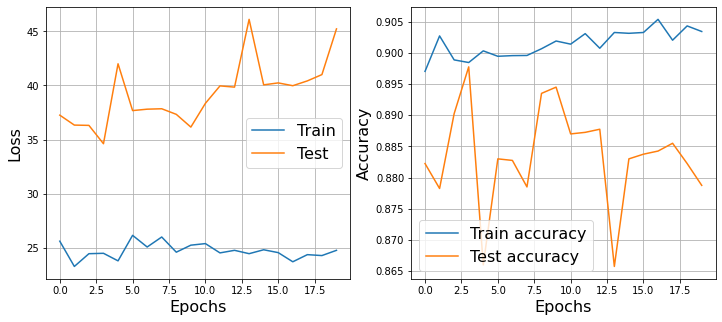

In [37]:
train(model, 20, 0.01, use_cuda = use_cuda)

### Errors analysis

In [0]:
wrong_X = []
correct_y = []
predicted_y = []

for sample in test_dataloader:
    X = sample[0]
    X = X.type(dtype)
    y = sample[1]
    
    if use_cuda:
        X = X.cuda()
        y = y.cuda()
            
    prediction = model(X).cpu().detach().numpy()
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))

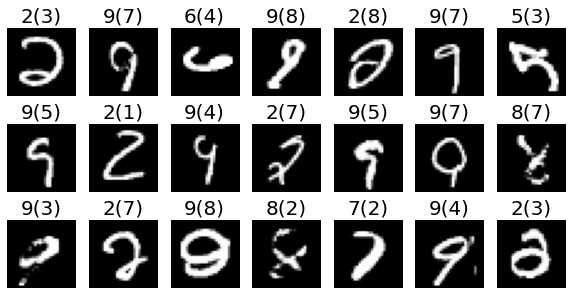

In [0]:
plt.figure(figsize=(10, 5))
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[i].cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[i], predicted_y[i]), fontsize=20)
    plt.axis('off')

### Test evaluation

In [0]:
class Testset():
    def __init__(self, data, source_transform):
        self.datas = data
        self.s_trans = source_transform
        self.to_pil = tsf.ToPILImage()
        self.to_tens = tsf.ToTensor()
        
    def __getitem__(self, index):
        data = self.datas[index]
        
        img = data['Image'].numpy()
        
        img = self.s_trans(img)
        
        return img
    
    def __len__(self):
        return len(self.datas)
    
s_trans = tsf.Compose([
    tsf.ToTensor()
]
)

In [0]:
test_dataset = Testset(test_data, s_trans)
testdataloader = DataLoader(test_dataset, batch_size=1)

In [0]:
submission_df = pd.DataFrame(columns = ['ImageId', 'Label'])

In [0]:
model = model.eval()

In [0]:
for ind,sample in enumerate(testdataloader):
    X = sample
    X = X.type(dtype)
    
    if use_cuda:
        X = X.cuda()
    
    prediction = model(X)
    
    label = np.argmax(prediction[0].cpu().detach().numpy())
    
    submission_df.loc[ind+1] = [ind+1, label]

Label:  7


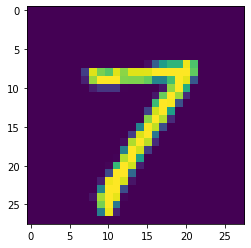

In [104]:
plt.imshow(X[0].cpu().squeeze(0).detach().numpy())
print("Label: ", label)

In [105]:
submission_df.head(5)

,ImageId,Label
1,1,1
2,2,0
3,3,1
4,4,4
5,5,0


In [0]:
submission_df.to_csv('/content/drive/My Drive/mnist_predictions.csv', index=False)

In [0]:
from google.colab import files
files.download("/content/drive/My Drive/mnist_predictions.csv")